<a href="https://colab.research.google.com/github/petervinhchau/public/blob/main/Copy_of_Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =====================================================================
# preprocessing dataset code cell
#
# This code cell downloads the Diamonds dataset from Google Drive,
# performs extensive data cleaning and preprocessing including:
#   - Loading data and initial data inspection.
#   - Removing duplicate rows and handling missing values.
#   - Detecting and removing outliers using the IQR method.
#   - Applying a log transformation to reduce skewness in selected features.
#   - Ordinal encoding of categorical features (cut, clarity, color, symmetry, polish).
#   - Splitting the dataset into training and testing sets.
#   - Standardizing numeric features based on the training set.
#   - Demonstrating feature selection by computing feature importances.
#   - Saving the preprocessed training and testing datasets to CSV files.
#   - Reloading and verifying the saved datasets.
#
# This cell is designed for use in a regression analysis project.
# =====================================================================

# Import necessary libraries
import os
import glob
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression

# ---------------------- Remove existing CSV files -------------------------
# Use Python's glob module to locate and remove any CSV files in the /content/ directory.
csv_files = glob.glob('/content/*.csv')
for file in csv_files:
    os.remove(file)

# ----------------------- Function Definitions ------------------------------

def download_diamond_data(file_path="/content/diamonds_ece219.csv",
                          file_id="1Z1a99rlufNP6qItwVY9fPPXO61y4ok55"):
    """
    Downloads the Diamonds dataset from Google Drive if not already present.

    Parameters:
        file_path (str): Destination file path for the CSV.
        file_id (str): Google Drive file ID.
    """
    if os.path.exists(file_path):
        print(f"File already exists at {file_path}, skipping download.")
    else:
        print(f"File not found at {file_path}, downloading now...")
        # Download the file using gdown
        gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)

    if os.path.exists(file_path):
        print("File downloaded and ready!")
        print(f"File size: {os.path.getsize(file_path)} bytes")
    else:
        raise FileNotFoundError("Could not download the dataset from Google Drive.")


def load_data(file_path="/content/diamonds_ece219.csv"):
    """
    Loads the CSV dataset into a pandas DataFrame and performs initial data checks.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: Loaded dataset.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"Initial dataset shape: {df.shape}")
    print("First three rows:")
    print(df.head(3))

    # Display DataFrame information and missing values
    print("\n--- Data Info ---")
    df.info()

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    return df


def handle_duplicates(df):
    """
    Removes duplicate rows from the DataFrame.

    Parameters:
        df (DataFrame): Input dataset.

    Returns:
        DataFrame: Dataset after duplicate removal.
    """
    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    final_count = len(df)
    print(f"Removed {initial_count - final_count} duplicate rows.")
    return df


def handle_missing_values(df, strategy="drop"):
    """
    Handles missing values in the DataFrame.

    Parameters:
        df (DataFrame): Input dataset.
        strategy (str): Strategy to handle missing data; 'drop' will remove rows,
                        'mean' or 'median' will fill numeric columns with the corresponding statistic.

    Returns:
        DataFrame: Dataset after handling missing values.
    """
    if strategy == "drop":
        initial_count = len(df)
        df.dropna(inplace=True)
        final_count = len(df)
        print(f"Dropped {initial_count - final_count} rows containing missing values.")
    elif strategy in ["mean", "median"]:
        for col in df.columns:
            if df[col].isnull().any():
                if pd.api.types.is_numeric_dtype(df[col]):
                    fill_value = df[col].mean() if strategy == "mean" else df[col].median()
                    df[col].fillna(fill_value, inplace=True)
                    print(f"Filled missing values in '{col}' with {strategy}={fill_value:.2f}")
                else:
                    # For non-numeric columns, fill with a placeholder
                    df[col].fillna("Missing", inplace=True)
                    print(f"Filled missing values in '{col}' with 'Missing'")
    return df


def detect_and_handle_outliers(df, numeric_cols, method="IQR", iqr_factor=1.5):
    """
    Detects and removes outliers from the DataFrame using the IQR method.

    Parameters:
        df (DataFrame): Input dataset.
        numeric_cols (list): List of numeric column names to check for outliers.
        method (str): Outlier detection method; currently supports "IQR".
        iqr_factor (float): Factor to determine the range for outliers.

    Returns:
        DataFrame: Dataset with outliers removed.
    """
    if method == "IQR":
        initial_count = len(df)
        # Loop through each numeric column and filter out outliers
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_factor * IQR
            upper_bound = Q3 + iqr_factor * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        final_count = len(df)
        print(f"IQR-based outlier removal: {initial_count - final_count} rows dropped.")

    return df


def apply_log_transform(df, cols):
    """
    Applies a log(x+1) transformation to reduce skewness in specified columns.
    Creates new columns with the suffix '_log'.

    Parameters:
        df (DataFrame): Input dataset.
        cols (list): List of column names to transform.

    Returns:
        DataFrame: Dataset with new log-transformed columns.
    """
    for c in cols:
        if (df[c] <= 0).any():
            # Calculate an offset if any values are zero or negative
            offset = 1 - df[c].min()  # Adjust so the minimum value becomes 1
            df[c + "_log"] = np.log(df[c] + offset)
        else:
            df[c + "_log"] = np.log1p(df[c])
        print(f"Applied log transform to '{c}'; new column: '{c}_log'")
    return df


def encode_cut_color_clarity(df):
    """
    Ordinally encodes the 'cut', 'clarity', and 'color' columns based on domain-specific grading.
    Drops rows with unknown categories in these columns.

    Parameters:
        df (DataFrame): Input dataset.

    Returns:
        DataFrame: Dataset with encoded categorical features.
    """
    # Define the expected order for each categorical variable
    cut_order = ["Fair", "Good", "Very Good", "Premium", "Excellent", "Ideal"]
    cut_mapping = {name: i + 1 for i, name in enumerate(cut_order)}

    clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
    clarity_mapping = {clar: i + 1 for i, clar in enumerate(clarity_order)}

    color_order = list("DEFGHIJ")
    color_mapping = {col: i + 1 for i, col in enumerate(color_order)}

    initial_count = len(df)

    # Map the categories to numbers
    if "cut" in df.columns:
        df["cut_encoded"] = df["cut"].map(cut_mapping)
    if "clarity" in df.columns:
        df["clarity_encoded"] = df["clarity"].map(clarity_mapping)
    if "color" in df.columns:
        df["color_encoded"] = df["color"].map(color_mapping)

    # Remove rows where encoding failed (i.e., resulted in NaN)
    df.dropna(subset=["cut_encoded", "clarity_encoded", "color_encoded"], inplace=True)
    final_count = len(df)
    print(f"Dropped {initial_count - final_count} rows with unknown cut/color/clarity categories.")

    return df


def encode_symmetry_polish(df):
    """
    Ordinally encodes the 'symmetry' and 'polish' columns.
    Drops rows with unknown categories.

    Parameters:
        df (DataFrame): Input dataset.

    Returns:
        DataFrame: Dataset with encoded 'symmetry' and 'polish' features.
    """
    possible_grades = ["Fair", "Good", "Very Good", "Excellent"]
    grade_mapping = {grade: i + 1 for i, grade in enumerate(possible_grades)}

    initial_count = len(df)
    if "symmetry" in df.columns:
        df["symmetry_encoded"] = df["symmetry"].map(grade_mapping)
    if "polish" in df.columns:
        df["polish_encoded"] = df["polish"].map(grade_mapping)

    # Remove rows with unknown categories
    df.dropna(subset=["symmetry_encoded", "polish_encoded"], inplace=True)
    final_count = len(df)
    print(f"Dropped {initial_count - final_count} rows with unknown symmetry/polish categories.")

    return df


def train_test_preprocessing(df, target="price", test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets and applies standardization
    to the numeric features based on the training data.

    Parameters:
        df (DataFrame): Input dataset.
        target (str): Name of the target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.

    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    # Define columns to exclude from features (non-numeric or unencoded categories)
    exclude_cols = {target, "cut", "clarity", "color", "symmetry", "polish",
                    "girdle_min", "girdle_max"}
    # Create list of feature columns
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    print("\nFeature columns used:", feature_cols)

    X = df[feature_cols].copy()
    y = df[target].copy()

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Split dataset: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")

    # Standardize numeric features based on training set statistics
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    scaler.fit(X_train[numeric_features])
    X_train[numeric_features] = scaler.transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    return X_train, X_test, y_train, y_test


def feature_selection_demo(X_train, y_train, method="mi"):
    """
    Demonstrates feature selection by computing and printing feature importance using
    either mutual information or F-regression.

    Parameters:
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        method (str): Method for feature selection ('mi' for mutual information,
                      else F-regression).

    Returns:
        DataFrame: The unmodified training features (for demonstration purposes).
    """
    if method == "mi":
        scores = mutual_info_regression(X_train, y_train)
    else:
        scores, _ = f_regression(X_train, y_train)

    # Pair feature names with their importance scores and sort them
    feature_scores = list(zip(X_train.columns, scores))
    feature_scores.sort(key=lambda x: x[1], reverse=True)

    print("\nFeature importances (method: {}):".format(method.upper()))
    for name, score in feature_scores:
        print(f"{name}: {score:.4f}")

    return X_train


def main_preprocessing_pipeline():
    """
    Runs the full preprocessing pipeline:
      1. Download dataset
      2. Load data and perform initial checks
      3. Remove duplicates and handle missing values
      4. Remove outliers from numeric features
      5. Apply log transformation to reduce skewness
      6. Encode categorical features ('cut', 'clarity', 'color')
      7. Encode additional categorical features ('symmetry', 'polish')
      8. Split dataset into training and testing sets and standardize features
      9. Perform feature selection demonstration
      10. Save the preprocessed training and testing datasets to CSV files
    """
    # 1. Download dataset if needed
    download_diamond_data()

    # 2. Load the dataset and inspect basic information
    df = load_data()

    # 3. Remove duplicate rows and handle missing values
    df = handle_duplicates(df)
    df = handle_missing_values(df, strategy="drop")

    # 4. Detect and remove outliers using the IQR method for selected numeric columns
    numeric_cols = ["carat", "length", "width", "depth", "depth_percent", "table_percent", "price"]
    df = detect_and_handle_outliers(df, numeric_cols, method="IQR", iqr_factor=1.5)

    # 5. Apply log transformation to reduce skewness for 'carat'
    df = apply_log_transform(df, ["carat"])
    # Optionally, you can apply log transform to 'price' if needed

    # 6. Encode the 'cut', 'clarity', and 'color' columns into numeric values
    df = encode_cut_color_clarity(df)

    # 7. Encode 'symmetry' and 'polish' columns
    df = encode_symmetry_polish(df)

    # 8. Split the dataset into training and testing sets and standardize numeric features
    X_train, X_test, y_train, y_test = train_test_preprocessing(df, target="price")

    # 9. Feature selection demo: print feature importances using mutual information
    X_train_fs = feature_selection_demo(X_train, y_train, method="mi")
    # (Optional) Align X_test with the same feature set: X_test_fs = X_test[X_train_fs.columns]

    # 10. Save preprocessed data to CSV files
    train_df = X_train_fs.copy()
    train_df["price"] = y_train.values
    train_output_path = "/content/shared_preprocessed_dataset_train.csv"
    train_df.to_csv(train_output_path, index=False)
    print(f"\nTrain preprocessed data saved to {train_output_path} (shape: {train_df.shape})")

    X_test_fs = X_test[X_train_fs.columns]
    test_df = X_test_fs.copy()
    test_df["price"] = y_test.values
    test_output_path = "/content/shared_preprocessed_dataset_test.csv"
    test_df.to_csv(test_output_path, index=False)
    print(f"Test preprocessed data saved to {test_output_path} (shape: {test_df.shape})")

    print("\nPreprocessing completed successfully!")


# ---------------------- RUN THE PREPROCESSING PIPELINE ----------------------

# 1. Execute the main pipeline to generate preprocessed train/test CSV files
main_preprocessing_pipeline()

# 2. Load the preprocessed train and test datasets
df_train = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
df_test = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")
print("\nTrain shape:", df_train.shape)
print("Test shape:", df_test.shape)

# 3. (Optional) Combine train and test sets for full dataset analysis and display initial rows
df = pd.concat([df_train, df_test], ignore_index=True)
print("Combined shape (train + test):", df.shape)
print(df.head())


File not found at /content/diamonds_ece219.csv, downloading now...


Downloading...
From: https://drive.google.com/uc?id=1Z1a99rlufNP6qItwVY9fPPXO61y4ok55
To: /content/diamonds_ece219.csv
100%|██████████| 12.7M/12.7M [00:00<00:00, 67.6MB/s]


File downloaded and ready!
File size: 12709058 bytes
Initial dataset shape: (149871, 15)
First three rows:
   Unnamed: 0 color clarity  carat        cut   symmetry     polish  \
0           0     E    VVS2   0.09  Excellent  Very Good  Very Good   
1           1     E    VVS2   0.09  Very Good  Very Good  Very Good   
2           2     E    VVS2   0.09  Excellent  Very Good  Very Good   

   depth_percent  table_percent  length  width  depth girdle_min girdle_max  \
0           62.7           59.0    2.85   2.87   1.79          M          M   
1           61.9           59.0    2.84   2.89   1.78        STK        STK   
2           61.1           59.0    2.88   2.90   1.77         TN          M   

   price  
0    200  
1    200  
2    200  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149871 entries, 0 to 149870
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     149871 

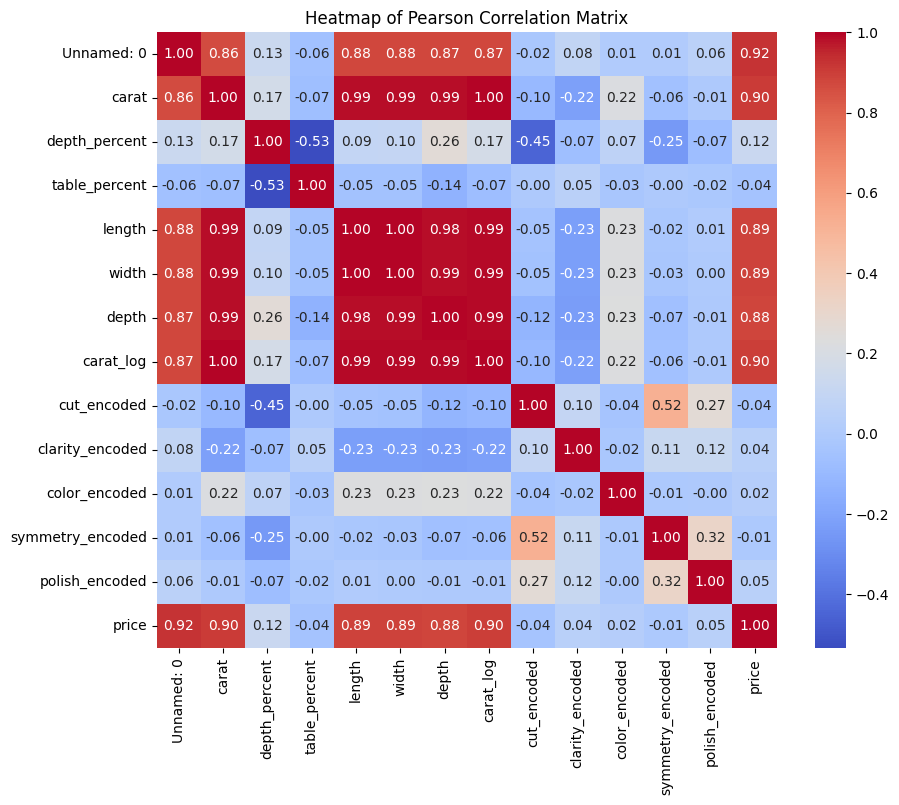

Features with highest absolute correlation to price:
Unnamed: 0    0.922644
carat         0.904472
carat_log     0.901792
width         0.890545
length        0.889830
Name: price, dtype: float64


In [2]:
# Q1.1 code cell: Calculates the correlation matrix for numerical features,
# visualizes it using a heatmap, and prints the top 5 features most correlated with 'price'.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose 'df' is already loaded/preprocessed and includes numerical columns plus 'price'
# 1. Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# 2. Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Pearson Correlation Matrix')
plt.show()

# 3. Show highest absolute correlations with target ('price')
target_correlations = corr_matrix['price'].drop('price')  # exclude self-correlation
sorted_corr = target_correlations.abs().sort_values(ascending=False)
print("Features with highest absolute correlation to price:")
print(sorted_corr.head(5))  # top 5


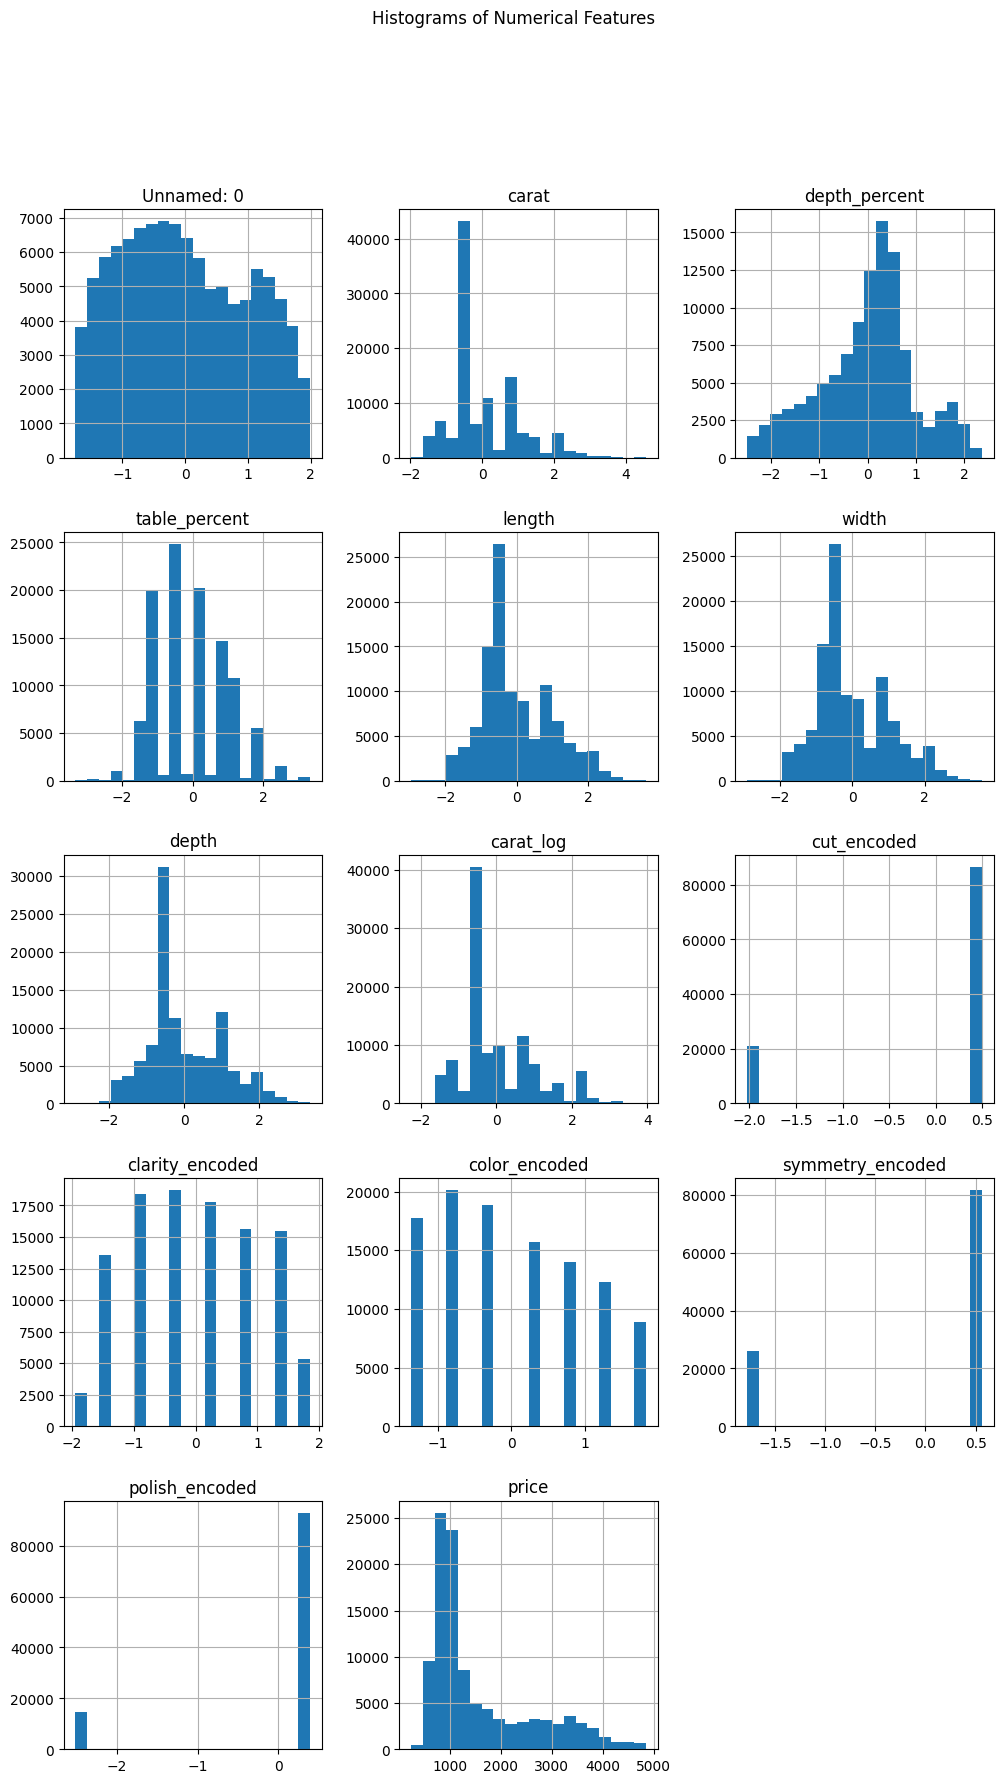

In [3]:
# Q1.2 code cell:
# This cell plots histograms for each numerical feature in the dataset with 3 graphs per row.
# Histograms show the distribution of each feature, which can reveal skewness and hint at potential transformations.
# Note: If a feature appears highly skewed, applying a transformation (e.g., logarithmic or standard scaling)
# might help normalize its distribution and boost regression model performance.

import pandas as pd
import matplotlib.pyplot as plt
import math

# Assume 'df' is already loaded and preprocessed, with all necessary numerical features present.

# Step 1: Determine the number of numerical columns and calculate the layout.
# - 'df.select_dtypes(include="number")' selects only numeric columns.
# - The total count of numerical columns is used to compute the required number of rows.
# - The layout is set to 3 graphs per row.
num_numeric = df.select_dtypes(include="number").shape[1]
num_rows = math.ceil(num_numeric / 3)

# Step 2: Generate histograms for each numerical column with the specified layout.
# - 'bins=20' divides data into 20 bins for each histogram.
# - 'figsize=(12, num_rows*4)' sets the overall figure size based on the number of rows.
df.hist(bins=20, figsize=(12, num_rows * 4), layout=(num_rows, 3))

# Step 3: Add a main title to the figure.
# - plt.suptitle() adds an overall title to all the histograms.
plt.suptitle('Histograms of Numerical Features')

# Step 4: Display the histograms.
# - plt.show() renders the figure.
plt.show()

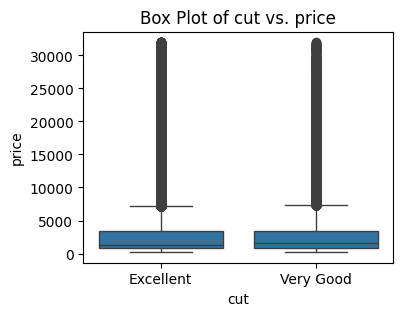

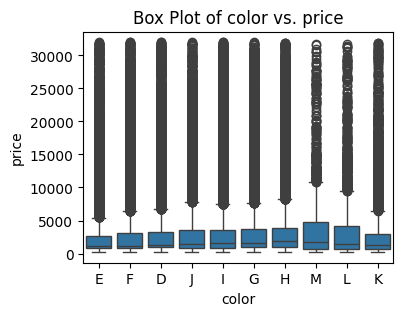

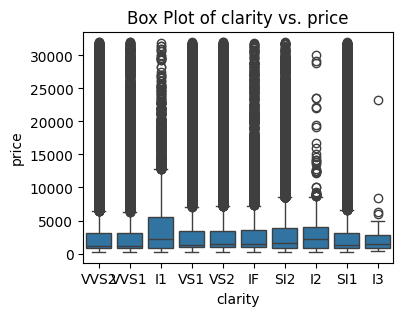

In [4]:
# Q1.3 code cell:
# This code cell addresses Question 1.3, which requires creating box plots
# of categorical features versus the target variable ('price').
# These plots help visualize how 'price' varies across different categories,
# providing insights about potential relationships or outliers.
# Note: The chart size has been reduced to 50% of the original dimensions.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the raw diamond dataset from the specified CSV file.
# - 'raw_df' holds the entire dataset with its original columns (including string-based categories).
raw_df = pd.read_csv("/content/diamonds_ece219.csv")

# Step 2: Define the categorical columns for which box plots will be created.
categorical_cols = ['cut', 'color', 'clarity']

# Step 3: Generate box plots for each categorical column vs. 'price'.
# - For each feature in 'categorical_cols', create a box plot showing 'price' distribution.
# - The original figure size (8, 6) is reduced by 50% to (4, 3) for a more compact display.
for cat in categorical_cols:
    if cat in raw_df.columns:
        plt.figure(figsize=(4, 3))
        sns.boxplot(x=raw_df[cat], y=raw_df['price'])
        plt.title(f'Box Plot of {cat} vs. price')
        plt.show()

# Step 4: The pipeline can continue with further cleaning or encoding of the categorical features as needed.


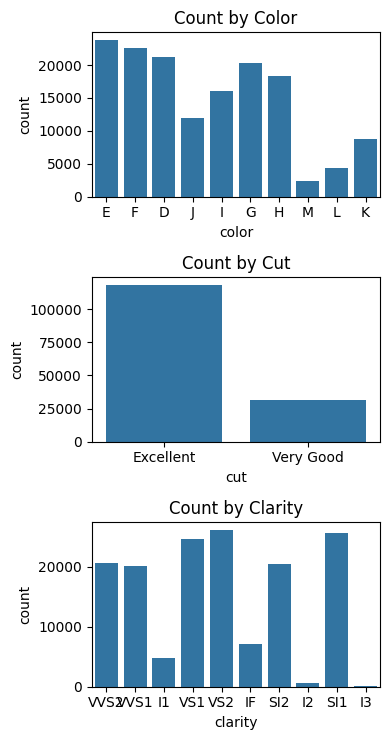

In [5]:
# Q1.4 code cell:
# This cell plots count plots for the categorical features in the Diamonds dataset,
# with one chart per row. Each plot shows the frequency distribution for a specific feature
# ('color', 'cut', and 'clarity'). The overall figure size is reduced to 50% of the original.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the Diamonds dataset from the CSV file.
# - The data is stored in raw_df, which contains the original categorical columns.
raw_df = pd.read_csv("diamonds_ece219.csv")

# Step 2: Create a figure with 3 rows and 1 column for count plots.
# - The original figure size was (8, 15), so reduced by 50% to (4, 7.5).
fig, axes = plt.subplots(3, 1, figsize=(4, 7.5))

# Step 3: Plot count plot for 'color'.
# - This plot shows the count of diamonds for each color category.
sns.countplot(x='color', data=raw_df, ax=axes[0])
axes[0].set_title("Count by Color")

# Step 4: Plot count plot for 'cut'.
# - This plot displays the frequency of each cut quality category.
sns.countplot(x='cut', data=raw_df, ax=axes[1])
axes[1].set_title("Count by Cut")

# Step 5: Plot count plot for 'clarity'.
# - This plot illustrates the count of diamonds for each clarity category.
sns.countplot(x='clarity', data=raw_df, ax=axes[2])
axes[2].set_title("Count by Clarity")

# Step 6: Adjust layout to ensure there is no overlapping between plots.
plt.tight_layout()

# Step 7: Render and display all count plots.
plt.show()


In [6]:
# === Q2.1 Code Cell ===
# This code cell loads the training and testing datasets,
# standardizes the feature columns using StandardScaler,
# and then prints out the shapes of the standardized datasets.
# This preprocessing step helps to normalize the features,
# ensuring they have a mean of 0 and a standard deviation of 1,
# which is important for many machine learning algorithms.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Load the training CSV file.
# - 'train_df' contains the training data with features and target variable ('price').
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
# - X_train holds all features except the target variable.
X_train = train_df.drop(columns=["price"])
# - y_train is the target variable.
y_train = train_df["price"]

# Step 2: Load the testing CSV file.
# - 'test_df' contains the testing data.
test_df = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")
# - X_test holds the features for testing.
X_test = test_df.drop(columns=["price"])
# - y_test is the target variable for testing.
y_test = test_df["price"]

# Step 3: Create and fit the StandardScaler on the training features.
# - The StandardScaler standardizes features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit(X_train)

# Step 4: Transform both the training and testing feature sets.
# - This ensures that both sets are scaled using the same parameters learned from X_train.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Print out a confirmation and the shapes of the resulting arrays.
# - This helps verify that the standardization process worked as expected.
print("Q2.1: Finished standardizing feature columns.")
print("Shapes:")
print("   X_train_scaled:", X_train_scaled.shape)
print("   X_test_scaled :", X_test_scaled.shape)
print("   y_train       :", y_train.shape)
print("   y_test        :", y_test.shape)


Q2.1: Finished standardizing feature columns.
Shapes:
   X_train_scaled: (86087, 13)
   X_test_scaled : (21522, 13)
   y_train       : (86087,)
   y_test        : (21522,)


In [7]:
# === Q2.2 Code Cell  ===
# This code cell performs feature selection using Mutual Information (MI) and
# then evaluates how removing the two features with the lowest MI scores affects
# linear regression performance on the training and testing datasets.
# The MI scores help identify features that may add little predictive power.
# Detailed performance metrics (RMSE) are computed for both the full and reduced models.

import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Step 1: Load the training dataset.
# - 'train_df' contains all the training data with features and the target variable ('price').
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
# - X_train: all features (all columns except 'price').
X_train = train_df.drop(columns=["price"])
# - y_train: the target variable.
y_train = train_df["price"]

# Load the testing dataset.
# - 'test_df' holds the testing data.
test_df = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")
# - X_test: all testing features.
X_test = test_df.drop(columns=["price"])
# - y_test: the target variable for testing.
y_test = test_df["price"]

# Step 2: Compute Mutual Information (MI) scores for each feature.
# - MI measures the dependency between each feature and the target variable.
# - A higher MI score indicates a stronger relationship.
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
# - 'feature_names' holds the names of the features in the dataset.
feature_names = X_train.columns

# Step 3: Pair each feature name with its MI score and sort by the MI score in ascending order.
# - Sorting in ascending order allows identification of the features with the lowest MI scores.
mi_with_features = list(zip(feature_names, mi_scores))
mi_with_features.sort(key=lambda x: x[1])  # Sorts based on the MI score (lowest first)

# Step 4: Print out the two features with the lowest MI scores.
lowest_two = mi_with_features[:2]
print("Q2.2: The two features with the lowest MI scores:")
for feat, score in lowest_two:
    print(f"   {feat} => MI score: {score:.5f}")

# Step 5: Compare model performance with all features vs. a reduced feature set.
# (a) Train a linear regression model using ALL features.
lr_all = LinearRegression()
lr_all.fit(X_train, y_train)
# - Compute Mean Squared Error (MSE) for training and testing datasets.
mse_train_all = mean_squared_error(y_train, lr_all.predict(X_train))
mse_test_all  = mean_squared_error(y_test, lr_all.predict(X_test))
# - Convert MSE to Root Mean Squared Error (RMSE) for easier interpretation.
rmse_train_all = np.sqrt(mse_train_all)
rmse_test_all  = np.sqrt(mse_test_all)

# (b) Train a linear regression model after removing the two lowest-MI features.
# - Identify the names of the two features to drop.
low_mi_names = [f[0] for f in lowest_two]
# - Create new training and testing datasets without these features.
X_train_reduced = X_train.drop(columns=low_mi_names)
X_test_reduced  = X_test.drop(columns=low_mi_names)

lr_reduced = LinearRegression()
lr_reduced.fit(X_train_reduced, y_train)
# - Compute MSE for the reduced feature models.
mse_train_reduced = mean_squared_error(y_train, lr_reduced.predict(X_train_reduced))
mse_test_reduced  = mean_squared_error(y_test,  lr_reduced.predict(X_test_reduced))
# - Convert MSE to RMSE.
rmse_train_reduced = np.sqrt(mse_train_reduced)
rmse_test_reduced  = np.sqrt(mse_test_reduced)

# Step 6: Print a performance comparison between the two models.
print(f"\nPerformance comparison (LinearRegression):")
print(f"   Train RMSE (all features)  : {rmse_train_all:.4f}")
print(f"   Train RMSE (reduced)       : {rmse_train_reduced:.4f}")
print(f"   Test RMSE  (all features)  : {rmse_test_all:.4f}")
print(f"   Test RMSE  (reduced)       : {rmse_test_reduced:.4f}")


Q2.2: The two features with the lowest MI scores:
   polish_encoded => MI score: 0.00937
   table_percent => MI score: 0.01981

Performance comparison (LinearRegression):
   Train RMSE (all features)  : 279.0881
   Train RMSE (reduced)       : 279.2147
   Test RMSE  (all features)  : 277.8531
   Test RMSE  (reduced)       : 278.0929


In [8]:
# === section 3.2 without question code cell ===
# Hey everyone, in this cell we're going to train several different models
# and compare their performance using average RMSE from 10-fold cross-validation.
# This helps us see which model might be better before diving into more detailed evaluation.
#
# NOTE: We're assuming that the data preparation from "code for q2.2" (i.e., X_train and y_train)
# is already in memory. So, no need to reload the data here.
#
# We'll train the following models:
#   1. Linear Regression
#   2. Decision Tree Regressor
#   3. Random Forest Regressor
#
# For each model, we'll calculate:
#   - Average RMSE on the training folds.
#   - Average RMSE on the validation folds.
#
# Let's get started!

import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

# Import models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Set a random state for reproducibility
random_state = 42

# Define our list of models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=random_state)),
    ("Random Forest Regressor", RandomForestRegressor(random_state=random_state, n_estimators=100))
]

# Define the number of folds for cross-validation
n_folds = 10

# Dictionary to store results for each model
cv_results_summary = {}

print("Training multiple algorithms using 10-fold cross-validation:\n")

# Loop through each model, run cross-validation, and compute average RMSE for training and validation sets
for name, model in models:
    print(f"Evaluating {name}...")

    # Perform cross-validation. We use 'neg_mean_squared_error' as scoring since CV maximizes score by default.
    cv_results = cross_validate(model, X_train, y_train, cv=n_folds,
                                scoring='neg_mean_squared_error',
                                return_train_score=True)

    # Convert the negative MSE values to RMSE for easier interpretation.
    # The train_score and test_score keys hold an array of scores for each fold.
    train_rmse = np.sqrt(-cv_results['train_score'])
    val_rmse = np.sqrt(-cv_results['test_score'])

    # Calculate average RMSE across all folds for both training and validation sets.
    avg_train_rmse = np.mean(train_rmse)
    avg_val_rmse = np.mean(val_rmse)

    # Save the results in our summary dictionary.
    cv_results_summary[name] = {
        "avg_train_rmse": avg_train_rmse,
        "avg_val_rmse": avg_val_rmse
    }

    # Print out the performance metrics for this model.
    print(f"  Average Training RMSE: {avg_train_rmse:.4f}")
    print(f"  Average Validation RMSE: {avg_val_rmse:.4f}\n")

print("Comparison complete! The above metrics show how each model performs on average across 10 folds.")


Training multiple algorithms using 10-fold cross-validation:

Evaluating Linear Regression...
  Average Training RMSE: 279.0814
  Average Validation RMSE: 279.2079

Evaluating Decision Tree Regressor...
  Average Training RMSE: 0.0000
  Average Validation RMSE: 1.4079

Evaluating Random Forest Regressor...
  Average Training RMSE: 0.6156
  Average Validation RMSE: 1.4440

Comparison complete! The above metrics show how each model performs on average across 10 folds.


In [9]:
# === section 3.3 with no question code cell ===
# Hey everyone, in this cell we’re going to evaluate our models using 10-fold cross-validation.
# We’ll calculate the average RMSE for both the training and validation sets.
# On top of that, for the Random Forest model, we’ll also measure the Out-of-Bag (OOB) error.
# This is super useful because OOB error gives us a quick estimate of how our model is doing without needing a separate validation set.
#
# NOTE: Make sure the variables X_train and y_train from the "code for q2.2" cell are available in memory.
# Let's jump in!

import numpy as np
from sklearn.model_selection import cross_validate  # for cross-validation
from sklearn.metrics import mean_squared_error        # to compute our error metric
from sklearn.linear_model import LinearRegression       # our baseline linear regression model
from sklearn.ensemble import RandomForestRegressor      # our Random Forest model

# Set a random state for reproducibility
random_state = 42

# ---------------------------
# Part 1: Linear Regression Evaluation with 10-Fold CV
# ---------------------------
print("=== Linear Regression: 10-Fold Cross-Validation Evaluation ===")

# Initialize our linear regression model
lr_model = LinearRegression()

# Perform 10-fold cross-validation. We use 'neg_mean_squared_error' because sklearn
# by default maximizes scores, so negative MSE allows us to convert it back later.
cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=10,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

# Since we get negative MSE values, we need to convert them to RMSE.
# We take the negative of the score and then the square root.
train_rmse_lr = np.sqrt(-cv_results_lr['train_score'])
val_rmse_lr = np.sqrt(-cv_results_lr['test_score'])

# Calculate the average RMSE for training and validation across all folds.
avg_train_rmse_lr = np.mean(train_rmse_lr)
avg_val_rmse_lr = np.mean(val_rmse_lr)

print("Linear Regression average RMSE on training folds: {:.4f}".format(avg_train_rmse_lr))
print("Linear Regression average RMSE on validation folds: {:.4f}".format(avg_val_rmse_lr))


# ---------------------------
# Part 2: Random Forest Evaluation with 10-Fold CV and OOB Error
# ---------------------------
print("\n=== Random Forest: 10-Fold Cross-Validation Evaluation ===")

# Initialize our random forest model WITHOUT OOB for cross-validation evaluation.
# We set n_estimators to 100 (default value, can be tuned later) and fix the random_state.
rf_model = RandomForestRegressor(random_state=random_state, n_estimators=100)

# Perform 10-fold cross-validation similarly for the random forest.
cv_results_rf = cross_validate(rf_model, X_train, y_train, cv=10,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

# Convert negative MSE scores to RMSE for both training and validation sets.
train_rmse_rf = np.sqrt(-cv_results_rf['train_score'])
val_rmse_rf = np.sqrt(-cv_results_rf['test_score'])

# Calculate the average RMSE values.
avg_train_rmse_rf = np.mean(train_rmse_rf)
avg_val_rmse_rf = np.mean(val_rmse_rf)

print("Random Forest average RMSE on training folds: {:.4f}".format(avg_train_rmse_rf))
print("Random Forest average RMSE on validation folds: {:.4f}".format(avg_val_rmse_rf))

# Now, let’s compute the Out-of-Bag (OOB) error for our Random Forest.
# OOB error is cool because it uses the samples not included in each bootstrap to give an unbiased error estimate.
print("\n=== Random Forest: Out-of-Bag (OOB) Error Calculation ===")

# Re-instantiate the random forest, this time with oob_score enabled.
rf_oob = RandomForestRegressor(random_state=random_state, n_estimators=100, oob_score=True)
rf_oob.fit(X_train, y_train)

# The oob_prediction_ attribute gives predictions for each training sample using the trees
# that did not see that sample during training.
oob_predictions = rf_oob.oob_prediction_

# Compute the RMSE for these OOB predictions.
oob_rmse = np.sqrt(mean_squared_error(y_train, oob_predictions))
print("Random Forest Out-of-Bag RMSE: {:.4f}".format(oob_rmse))

# That’s it for this section!
# We’ve successfully evaluated our models using 10-fold cross-validation and computed OOB error for Random Forest.


=== Linear Regression: 10-Fold Cross-Validation Evaluation ===
Linear Regression average RMSE on training folds: 279.0814
Linear Regression average RMSE on validation folds: 279.2079

=== Random Forest: 10-Fold Cross-Validation Evaluation ===
Random Forest average RMSE on training folds: 0.6156
Random Forest average RMSE on validation folds: 1.4440

=== Random Forest: Out-of-Bag (OOB) Error Calculation ===
Random Forest Out-of-Bag RMSE: 1.5411


In [10]:
# === q4.1 code cell ===
"""
In this cell, we train three models on our training data:
   (a) Ordinary Least Squares (OLS) - linear regression without regularization.
   (b) Lasso Regression - linear regression with L1 regularization.
   (c) Ridge Regression - linear regression with L2 regularization.

Objective functions:
   OLS Objective:
       min_beta (1/2N) * sum((y_i - X_i beta)^2)
   Lasso Objective:
       min_beta (1/2N) * sum((y_i - X_i beta)^2) + alpha * sum(|beta_j|)
       -> The L1 penalty can force some coefficients to exactly zero, promoting sparsity.
   Ridge Objective:
       min_beta (1/2N) * sum((y_i - X_i beta)^2) + alpha * sum(beta_j^2)
       -> The L2 penalty shrinks the coefficients toward zero, but typically does not set any to zero.

What does this mean in practice?
   - OLS minimizes error without any regularization.
   - Lasso may remove features by setting some coefficients to zero.
   - Ridge reduces the magnitude of coefficients without eliminating any features.

Note: For a meaningful comparison, it is advisable to standardize features.
Assuming X_train and y_train are already loaded from previous cells (e.g., in "q2.2 code cell").

This cell addresses the question:
"Explain how each regularization scheme affects the learned parameter set."
by training and displaying coefficients for OLS, Lasso, and Ridge.
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Uncomment the following lines if X_train and y_train are not already in memory:
#train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
#X_train = train_df.drop(columns=["price"])
#y_train = train_df["price"]

models = [
    ("Ordinary Least Squares (OLS)", LinearRegression()),
    ("Lasso Regression", Lasso(alpha=1.0, random_state=42, max_iter=10000)),
    ("Ridge Regression", Ridge(alpha=1.0, random_state=42))
]

coefficients = {}

print("Training models and comparing learned coefficients:\n")

for name, model in models:
    model.fit(X_train, y_train)
    coef = model.coef_
    coefficients[name] = dict(zip(X_train.columns, coef))

    print(f"{name}:")
    for feature, value in coefficients[name].items():
        print(f"   {feature}: {value:.4f}")
    print("\n")


Training models and comparing learned coefficients:

Ordinary Least Squares (OLS):
   Unnamed: 0: 402.3693
   carat: 628.6617
   depth_percent: 20.3709
   table_percent: -6.7768
   length: -221.0994
   width: -184.7331
   depth: -638.9461
   carat_log: 1038.2964
   cut_encoded: 32.0461
   clarity_encoded: 133.0334
   color_encoded: -102.4517
   symmetry_encoded: -0.0615
   polish_encoded: 7.1452


Lasso Regression:
   Unnamed: 0: 390.6814
   carat: 1119.8791
   depth_percent: -0.0000
   table_percent: 0.0352
   length: -200.6794
   width: -23.1116
   depth: -254.4075
   carat_log: 0.0000
   cut_encoded: 21.3599
   clarity_encoded: 138.2697
   color_encoded: -105.6359
   symmetry_encoded: -0.9222
   polish_encoded: 6.5523


Ridge Regression:
   Unnamed: 0: 402.7074
   carat: 644.9394
   depth_percent: 19.3421
   table_percent: -6.5906
   length: -222.0883
   width: -183.2791
   depth: -626.7095
   carat_log: 1009.2715
   cut_encoded: 31.8452
   clarity_encoded: 132.9639
   color_encoded

In [11]:
# Q4.2: Finding the Best Regularization Scheme (Ridge vs. Lasso) and Optimal Alpha
# This code cell compares Ridge and Lasso regularization by searching for the best alpha value using
# cross-validation. It then trains final models with the optimal alpha values and evaluates their test set RMSE.
# All runtime warnings have been suppressed for a cleaner output.
# RMSE values are printed with 4 digits after the decimal point.

import warnings
warnings.filterwarnings("ignore")  # Suppress all runtime warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# Step 1: Load preprocessed training and testing datasets.
# - 'train_df' and 'test_df' contain the data including all features and the target variable 'price'.
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
test_df = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Separate features and target variable for training.
X_train = train_df.drop(columns=["price"])
y_train = train_df["price"]

# Separate features and target variable for testing.
X_test  = test_df.drop(columns=["price"])
y_test  = test_df["price"]

# Step 2: Establish a baseline using Ordinary Least Squares (OLS) Linear Regression.
lr = LinearRegression()
lr.fit(X_train, y_train)
# Calculate the baseline RMSE on the test set.
baseline_rmse = np.sqrt(np.mean((y_test - lr.predict(X_test))**2))
print("Baseline (OLS) Test RMSE:", f"{baseline_rmse:.4f}")

# Step 3: Hyperparameter search for Ridge and Lasso regression.
# - A simple grid search over a list of alpha values.
alphas = [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
n_folds = 5  # Number of folds for cross-validation

# Initialize variables to store the best RMSE and corresponding alpha for Ridge and Lasso.
best_ridge_rmse = float("inf")
best_ridge_alpha = None
best_lasso_rmse = float("inf")
best_lasso_alpha = None

# Loop through each alpha value for both Ridge and Lasso using K-fold cross-validation.
for alpha in alphas:
    # ---- Ridge Regression ----
    ridge = Ridge(alpha=alpha, random_state=42)
    cv_scores_ridge = cross_val_score(
        ridge, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=n_folds
    )
    # The negative RMSE is returned, so take the negative mean to get the average RMSE.
    mean_rmse_ridge = -np.mean(cv_scores_ridge)

    # Update the best Ridge parameters if current alpha gives a lower RMSE.
    if mean_rmse_ridge < best_ridge_rmse:
        best_ridge_rmse = mean_rmse_ridge
        best_ridge_alpha = alpha

    # ---- Lasso Regression ----
    lasso = Lasso(alpha=alpha, random_state=42)
    cv_scores_lasso = cross_val_score(
        lasso, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=n_folds
    )
    # Compute the average RMSE for Lasso.
    mean_rmse_lasso = -np.mean(cv_scores_lasso)

    # Update the best Lasso parameters if current alpha gives a lower RMSE.
    if mean_rmse_lasso < best_lasso_rmse:
        best_lasso_rmse = mean_rmse_lasso
        best_lasso_alpha = alpha

# Print cross-validation results for both Ridge and Lasso.
print("\nCross-Validation Results:")
print(f"  Best Ridge alpha={best_ridge_alpha} => CV RMSE={best_ridge_rmse:.4f}")
print(f"  Best Lasso alpha={best_lasso_alpha} => CV RMSE={best_lasso_rmse:.4f}")

# Step 4: Train final models with the best alpha values and evaluate on the test set.
# ---- Final Ridge Model ----
best_ridge_model = Ridge(alpha=best_ridge_alpha, random_state=42)
best_ridge_model.fit(X_train, y_train)
test_rmse_ridge = np.sqrt(np.mean((y_test - best_ridge_model.predict(X_test))**2))

# ---- Final Lasso Model ----
best_lasso_model = Lasso(alpha=best_lasso_alpha, random_state=42)
best_lasso_model.fit(X_train, y_train)
test_rmse_lasso = np.sqrt(np.mean((y_test - best_lasso_model.predict(X_test))**2))

# Print test set performance for all models.
print("\nTest Set Performance:")
print(f"  OLS Test RMSE           : {baseline_rmse:.4f}")
print(f"  Best Ridge Test RMSE (alpha={best_ridge_alpha}): {test_rmse_ridge:.4f}")
print(f"  Best Lasso Test RMSE (alpha={best_lasso_alpha}): {test_rmse_lasso:.4f}")


Baseline (OLS) Test RMSE: 277.8531

Cross-Validation Results:
  Best Ridge alpha=5.0 => CV RMSE=279.2152
  Best Lasso alpha=0.01 => CV RMSE=279.3991

Test Set Performance:
  OLS Test RMSE           : 277.8531
  Best Ridge Test RMSE (alpha=5.0): 277.8703
  Best Lasso Test RMSE (alpha=0.01): 278.0666


In [12]:
# =============================== Q5.1 CODE CELL ===============================
# This code cell performs a polynomial regression experiment using Ridge regression.
# It expands selected features to a polynomial degree (degree=2 here), fits a Ridge model,
# and then ranks the polynomial features by the absolute value of their coefficients.
# Finally, it prints out the top 10 most salient features along with the training RMSE.
# All numeric outputs are formatted to 4 digits after the decimal point.

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Step 1: Load the preprocessed training dataset.
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")

# Step 2: Drop an index-like column if it exists.
if "Unnamed: 0" in train_df.columns:
    train_df.drop(columns=["Unnamed: 0"], inplace=True)

# Step 3: Optionally sample the data to reduce memory usage.
# For instance, if the training set is very large, sample 20,000 rows.
train_df = train_df.sample(n=20000, random_state=42)

# Step 4: Separate features and the target variable.
X_train_full = train_df.drop(columns=["price"])
y_train_full = train_df["price"]

# Step 5: Select a few relevant features based on correlation or domain knowledge.
# Adjust this list as needed. Here, 5 likely relevant features are chosen.
selected_features = ["carat", "carat_log", "length", "width", "depth_percent"]
X_train = X_train_full[selected_features]

# Step 6: Expand the selected features into polynomial features (degree=2).
poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Step 7: Fit a Ridge regression model using an iterative solver suitable for large datasets.
ridge = Ridge(alpha=1.0, solver='saga', max_iter=3000, random_state=42)
ridge.fit(X_train_poly, y_train_full)

# Step 8: Extract the feature names from the polynomial expansion and pair them with their coefficients.
feat_names = poly.get_feature_names_out(selected_features)
coeffs = ridge.coef_
feat_coef_pairs = list(zip(feat_names, coeffs))
# Sort the feature-coefficient pairs by the absolute value of the coefficients, in descending order.
feat_coef_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

# Step 9: Print the top 10 features by absolute coefficient value.
top_n = 10
print(f"Q5.1: Most Salient Features (Degree={poly_degree}, Ridge alpha=1.0)")
for i, (feat, cval) in enumerate(feat_coef_pairs[:top_n], start=1):
    print(f"{i}. {feat:25s} => coefficient={cval:.4f}")

# Step 10: Compute and print the training RMSE for the polynomial Ridge model.
y_pred_train = ridge.predict(X_train_poly)
rmse_train = np.sqrt(mean_squared_error(y_train_full, y_pred_train))
print(f"\nTrain RMSE (poly deg={poly_degree}, alpha=1.0): {rmse_train:.4f}")


Q5.1: Most Salient Features (Degree=2, Ridge alpha=1.0)
1. carat_log length          => coefficient=1028.7494
2. carat_log width           => coefficient=1010.6541
3. carat carat_log           => coefficient=-907.1271
4. carat_log depth_percent   => coefficient=861.3939
5. width                     => coefficient=583.2391
6. length^2                  => coefficient=-568.7023
7. carat depth_percent       => coefficient=-468.7536
8. carat width               => coefficient=-371.9073
9. width depth_percent       => coefficient=-295.1852
10. carat_log                 => coefficient=244.8058

Train RMSE (poly deg=2, alpha=1.0): 400.2599


In [13]:
# =============================== Q5.2 CODE CELL ===============================
# This code cell searches for the best polynomial degree for a Ridge regression model.
# It loads the training and testing datasets, selects a subset of numeric features,
# and performs a grid search over polynomial degrees (from 1 to 3) using cross-validation.
# The model with the lowest CV RMSE is then retrained on the entire training subset,
# and its performance is evaluated on the test set.
# All RMSE values are printed with 4 digits after the decimal point.

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Step 1: Load the training and testing datasets.
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
test_df  = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Step 2: Drop index-like columns if they exist.
for c in ["Unnamed: 0"]:
    if c in train_df.columns:
        train_df.drop(columns=[c], inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=[c], inplace=True)

# Step 3: Optionally sample the training data to reduce memory usage.
# Here, 20,000 rows are sampled from the training set.
train_df = train_df.sample(n=20000, random_state=42)

# Step 4: Separate features and target variable.
X_train_full = train_df.drop(columns=["price"])
y_train_full = train_df["price"]
X_test_full  = test_df.drop(columns=["price"])
y_test_full  = test_df["price"]

# Step 5: Select a subset of numeric features to avoid combinatorial explosion in polynomial features.
# Adjust this list as needed; here we choose 5 features.
selected_features = ["carat", "carat_log", "length", "width", "depth_percent"]
X_train = X_train_full[selected_features]
X_test  = X_test_full[selected_features]

# Step 6: Search over polynomial degrees to find the best degree via cross-validation.
# We consider degrees 1, 2, and 3.
degrees = [1, 2, 3]  # Optionally, degree 4 can be added if computational resources allow.
alpha = 1.0  # Regularization strength for Ridge regression.

best_degree = None
best_cv_rmse = float("inf")

for deg in degrees:
    # Create polynomial features of the specified degree.
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)

    # Initialize Ridge regression with the specified alpha and solver.
    ridge = Ridge(alpha=alpha, solver='saga', max_iter=3000, random_state=42)

    # Perform 3-fold cross-validation using negative RMSE as the scoring metric.
    cv_rmse_scores = cross_val_score(
        ridge,
        X_train_poly,
        y_train_full,
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1
    )

    # Compute the mean RMSE (taking the negative mean because scores are returned as negatives).
    mean_rmse = -np.mean(cv_rmse_scores)
    print(f"Degree={deg}, CV Mean RMSE={mean_rmse:.4f}")

    # Update the best degree if the current one yields a lower mean RMSE.
    if mean_rmse < best_cv_rmse:
        best_cv_rmse = mean_rmse
        best_degree = deg

print(f"\nBest polynomial degree (from CV): {best_degree}, CV RMSE={best_cv_rmse:.4f}")

# Step 7: Refit the Ridge model using the best polynomial degree on the entire training subset.
poly_best = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_best = poly_best.fit_transform(X_train)
X_test_best  = poly_best.transform(X_test)

ridge_best = Ridge(alpha=alpha, solver='saga', max_iter=3000, random_state=42)
ridge_best.fit(X_train_best, y_train_full)

# Step 8: Evaluate the final model on the test set.
y_pred_test = ridge_best.predict(X_test_best)
test_rmse = np.sqrt(mean_squared_error(y_test_full, y_pred_test))
print(f"Test RMSE (degree={best_degree}, alpha={alpha}): {test_rmse:.4f}")


Degree=1, CV Mean RMSE=435.7970
Degree=2, CV Mean RMSE=400.8986
Degree=3, CV Mean RMSE=394.4178

Best polynomial degree (from CV): 3, CV RMSE=394.4178
Test RMSE (degree=3, alpha=1.0): 393.0779


In [14]:
# ========================== Q6.1 CODE CELL ==========================
# This code cell performs hyperparameter tuning for an MLP regressor.
# It loads and optionally samples preprocessed training and testing data,
# standardizes the features, and then systematically explores a small grid of
# hyperparameters (hidden layer sizes and alpha for weight decay) using 5-fold cross-validation.
# The best configuration is then used to train a final model and evaluate its test RMSE.
# All RMSE outputs are formatted to 4 digits after the decimal point.

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Step 1: Load preprocessed training and testing CSVs.
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
test_df  = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Step 2: Optionally drop index-like columns (e.g., 'Unnamed: 0') if present.
for c in ["Unnamed: 0"]:
    if c in train_df.columns:
        train_df.drop(columns=[c], inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=[c], inplace=True)

# Step 3: Optionally sample the training data to reduce runtime.
# Here, 20,000 rows are sampled from the training set.
train_df = train_df.sample(n=20000, random_state=42)

# Step 4: Separate features (X) and target (y) from both training and testing sets.
X_train = train_df.drop(columns=["price"])
y_train = train_df["price"].values
X_test  = test_df.drop(columns=["price"])
y_test  = test_df["price"].values

# Step 5: Standard scale the features, which is especially important for MLPs.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Step 6: Define a small search space for MLP hyperparameters (fewer than 20 combinations).
hidden_layer_options = [
    (64,),      # single hidden layer with 64 neurons
    (64, 64),   # two hidden layers with 64 neurons each
    (128, 64),  # two hidden layers: first with 128 neurons, then 64 neurons
]
alpha_options = [1e-5, 1e-4, 1e-3, 1e-2]  # Different values for weight decay

# Set up 5-fold cross-validation.
n_folds = 5
best_params = None
best_cv_rmse = float("inf")

# Loop over all combinations of hidden layers and alpha.
for hl in hidden_layer_options:
    for alpha in alpha_options:
        # Build the MLP regressor with the current hyperparameters.
        mlp = MLPRegressor(
            hidden_layer_sizes=hl,
            alpha=alpha,
            activation="relu",       # activation function
            solver="adam",           # optimizer
            max_iter=300,            # maximum iterations (can be increased if needed)
            random_state=42
        )

        # Perform 5-fold cross-validation using negative RMSE as the scoring metric.
        cv_scores = cross_val_score(
            mlp, X_train_scaled, y_train,
            scoring='neg_root_mean_squared_error',
            cv=n_folds, n_jobs=-1
        )
        # Calculate the mean RMSE from the cross-validation scores.
        mean_rmse = -np.mean(cv_scores)
        print(f"Hidden={hl}, alpha={alpha}, CV RMSE={mean_rmse:.4f}")

        # Update best parameters if the current configuration yields a lower CV RMSE.
        if mean_rmse < best_cv_rmse:
            best_cv_rmse = mean_rmse
            best_params = (hl, alpha)

print(f"\nBest hyperparameters based on CV:")
print(f"   Hidden Layers={best_params[0]}, alpha={best_params[1]} => CV RMSE={best_cv_rmse:.4f}")

# Step 7: Train the final MLP regressor on the entire training set with the best hyperparameters.
mlp_final = MLPRegressor(
    hidden_layer_sizes=best_params[0],
    alpha=best_params[1],
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)
mlp_final.fit(X_train_scaled, y_train)

# Step 8: Evaluate the final model on the test set.
y_pred_test = mlp_final.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE with best MLP: {test_rmse:.4f}")


Hidden=(64,), alpha=1e-05, CV RMSE=213.0274
Hidden=(64,), alpha=0.0001, CV RMSE=213.0270
Hidden=(64,), alpha=0.001, CV RMSE=212.4332
Hidden=(64,), alpha=0.01, CV RMSE=212.8868
Hidden=(64, 64), alpha=1e-05, CV RMSE=184.2005
Hidden=(64, 64), alpha=0.0001, CV RMSE=184.3297
Hidden=(64, 64), alpha=0.001, CV RMSE=183.9736
Hidden=(64, 64), alpha=0.01, CV RMSE=184.3907
Hidden=(128, 64), alpha=1e-05, CV RMSE=184.0327
Hidden=(128, 64), alpha=0.0001, CV RMSE=184.2686
Hidden=(128, 64), alpha=0.001, CV RMSE=184.0680
Hidden=(128, 64), alpha=0.01, CV RMSE=183.6046

Best hyperparameters based on CV:
   Hidden Layers=(128, 64), alpha=0.01 => CV RMSE=183.6046
Test RMSE with best MLP: 180.3497


In [15]:
# === Q6.2 (Optional) Code Cell ===
# This code cell compares the performance of a simple Linear Regression model
# with an MLPRegressor on the standardized dataset. The goal is to assess
# how the performance (measured by RMSE) of a neural network compares to that of
# linear regression. All RMSE values are printed with 4 digits after the decimal point.

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Step 1: Load preprocessed training and testing datasets.
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
test_df  = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Step 2: Drop index-like columns if they exist.
for c in ["Unnamed: 0"]:
    if c in train_df.columns:
        train_df.drop(columns=[c], inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=[c], inplace=True)

# Step 3: Optionally sample the training data to reduce runtime (using 20,000 rows).
train_df = train_df.sample(n=20000, random_state=42)

# Step 4: Separate features (X) and target (y) for both training and testing sets.
X_train = train_df.drop(columns=["price"])
y_train = train_df["price"].values
X_test  = test_df.drop(columns=["price"])
y_test  = test_df["price"].values

# Step 5: Standardize features, which is especially important for neural networks.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Step 6: Train a simple Linear Regression model as a baseline.
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression Test RMSE: {lr_rmse:.4f}")

# Step 7: Train an MLPRegressor with a fixed architecture (two hidden layers of 64 neurons each)
# and a weight decay (alpha) of 1e-4.
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    alpha=1e-4,
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
mlp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"MLP (64,64) alpha=1e-4 Test RMSE: {mlp_rmse:.4f}")


Linear Regression Test RMSE: 300.5162
MLP (64,64) alpha=1e-4 Test RMSE: 181.0763


Validation RMSE (max_depth=4): 292.0374


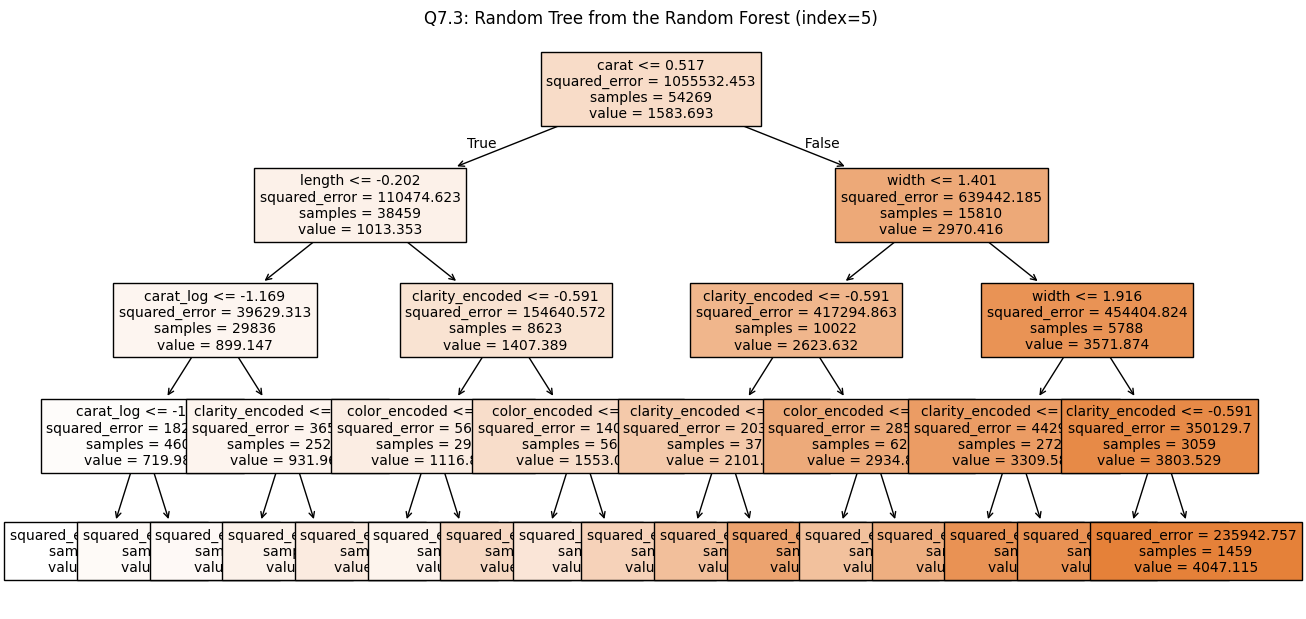


Tree Node Information (Grouped by Level):

Row 1:
  Box 1: carat <= 0.5173, squared_error = 1055532.4531, samples = 54269, value = 1583.6926

Row 2:
  Box 1: length <= -0.2020, squared_error = 110474.6234, samples = 38459, value = 1013.3534
  Box 2: width <= 1.4011, squared_error = 639442.1852, samples = 15810, value = 2970.4163

Row 3:
  Box 1: carat_log <= -1.1690, squared_error = 39629.3133, samples = 29836, value = 899.1472
  Box 2: clarity_encoded <= -0.5907, squared_error = 154640.5722, samples = 8623, value = 1407.3887
  Box 3: clarity_encoded <= -0.5907, squared_error = 417294.8633, samples = 10022, value = 2623.6324
  Box 4: width <= 1.9158, squared_error = 454404.8240, samples = 5788, value = 3571.8737

Row 4:
  Box 1: carat_log <= -1.4204, squared_error = 18222.1034, samples = 4601, value = 719.9806
  Box 2: clarity_encoded <= -0.5907, squared_error = 36593.1868, samples = 25235, value = 931.9682
  Box 3: color_encoded <= 1.0289, squared_error = 56240.3909, samples = 2924, 

In [16]:
# === Q7.3 code cell ===
# This code cell loads a combined dataset from preprocessed train and test CSV files,
# trains a small Random Forest regressor (with max_depth=4), and randomly selects one tree from the forest.
# The selected tree is then plotted to visualize its structure, allowing inspection of the root node
# and its splitting feature relative to prior analyses. In this version, the figure size for the tree plot
# is reduced to 75% of the original size (i.e., from 20x10 to 15x7.5). All numerical outputs are formatted
# with 4 digits after the decimal point.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree  # For visualizing a single decision tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random
from collections import deque

# ---------------------------------------------------------------------
# Step 1: Load and combine preprocessed train/test datasets.
# ---------------------------------------------------------------------
# Load the training dataset.
df_train = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
# Load the testing dataset.
df_test  = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Remove any index-like columns if present (e.g., "Unnamed: 0").
for c in ["Unnamed: 0"]:
    if c in df_train.columns:
        df_train.drop(columns=[c], inplace=True)
    if c in df_test.columns:
        df_test.drop(columns=[c], inplace=True)

# Combine the two datasets into one larger DataFrame.
df = pd.concat([df_train, df_test], ignore_index=True)

# Separate the combined data into features (X) and the target variable (y).
# X contains all columns except "price"; y contains the "price" values.
X = df.drop(columns=["price"])
y = df["price"].values

# ---------------------------------------------------------------------
# Step 2: Split the dataset into training and validation sets.
# ---------------------------------------------------------------------
# Reserve 20% of the data for validation. Use random_state=42 for reproducibility.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------------------
# Step 3: Train a Random Forest regressor with max_depth=4.
# ---------------------------------------------------------------------
# Use n_estimators=10 to create a small forest for easier tree visualization.
rf = RandomForestRegressor(
    n_estimators=10,     # Small forest for quick plotting
    max_depth=4,         # Limit tree depth to 4 levels as specified
    random_state=42
)
rf.fit(X_train, y_train)

# Optional: Evaluate the model on the validation set.
val_preds = rf.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE (max_depth=4): {val_rmse:.4f}")

# ---------------------------------------------------------------------
# Step 4: Randomly select one tree from the forest and plot its structure.
# ---------------------------------------------------------------------
# Randomly pick an index between 0 and (n_estimators - 1).
rand_tree_index = random.randint(0, rf.n_estimators - 1)
# Retrieve the selected tree.
one_tree = rf.estimators_[rand_tree_index]

# Create a new figure for the tree plot.
# The figure size is set to 75% of the original size (15x7.5 instead of 20x10).
plt.figure(figsize=(15, 7.5))
plot_tree(
    decision_tree=one_tree,
    feature_names=X.columns,  # Label nodes with corresponding feature names
    filled=True,              # Color nodes based on impurity
    max_depth=4,              # Display the full tree structure as trained
    fontsize=10               # Font size inside each box; adjust if necessary
)
plt.title(f"Q7.3: Random Tree from the Random Forest (index={rand_tree_index})")
plt.show()

# ---------------------------------------------------------------------
# Step 5: Extract and print text information from each node in the tree.
# ---------------------------------------------------------------------
# Perform a level-order (breadth-first) traversal of the tree.
# This prints detailed information (threshold, impurity, sample count, value) for each node,
# grouped by tree level (each level corresponds to a row in the tree plot).
tree = one_tree.tree_  # Access the underlying tree structure
feature_names = list(X.columns)  # List of feature names

print("\nTree Node Information (Grouped by Level):\n")
# Initialize a queue with the root node (index 0) at level 1.
queue = deque([(0, 1)])
levels = {}  # Dictionary to hold node info for each level

while queue:
    node, level = queue.popleft()
    n_samples = tree.n_node_samples[node]
    impurity = tree.impurity[node]
    # For regression trees, the 'value' is stored as an array; extract the scalar.
    value = tree.value[node][0, 0]

    # Check if the node is a leaf (i.e., no children).
    if tree.children_left[node] == tree.children_right[node]:
        node_info = (f"Leaf: samples = {n_samples}, "
                     f"value = {value:.4f}, "
                     f"squared_error = {impurity:.4f}")
    else:
        # For non-leaf nodes, retrieve the splitting feature and threshold.
        feature = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        node_info = (f"{feature} <= {threshold:.4f}, "
                     f"squared_error = {impurity:.4f}, "
                     f"samples = {n_samples}, "
                     f"value = {value:.4f}")

    # Store the node info by level.
    if level not in levels:
        levels[level] = []
    levels[level].append(node_info)

    # If the node is not a leaf, add its children to the queue with the next level.
    if tree.children_left[node] != tree.children_right[node]:
        queue.append((tree.children_left[node], level + 1))
        queue.append((tree.children_right[node], level + 1))

# Print the node information for each level (each level corresponds to a row in the tree plot).
for level in sorted(levels.keys()):
    print(f"Row {level}:")
    for i, info in enumerate(levels[level], start=1):
        print(f"  Box {i}: {info}")
    print("")  # Blank line between rows

# ---------------------------------------------------------------------
# Step 6: Provide a discussion prompt for further analysis.
# ---------------------------------------------------------------------


In [17]:
# === Q7.4 code cell ===
# This code cell computes the Out-of-Bag (OOB) error for a Random Forest regressor.
# OOB error gives an internal measure of model generalization without a separate validation set.
# We load the dataset, train a Random Forest with OOB enabled, and then print the OOB R² score
# (and OOB RMSE if available). All numerical outputs are printed with 4 digits after the decimal point.

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------------------
# Step 1: Load and preprocess the training dataset.
# ---------------------------------------------------------------------
df_train = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")

# Remove any unwanted index-like columns (e.g., "Unnamed: 0") if they exist.
for c in ["Unnamed: 0"]:
    if c in df_train.columns:
        df_train.drop(columns=[c], inplace=True)

# Separate features (X_train) and target variable (y_train).
X_train = df_train.drop(columns=["price"])
y_train = df_train["price"].values

# ---------------------------------------------------------------------
# Step 2: Train a Random Forest regressor with OOB estimates enabled.
# ---------------------------------------------------------------------
# n_estimators=50 for more stable OOB predictions; max_depth=None allows full tree growth.
rf_oob = RandomForestRegressor(
    n_estimators=50,     # More trees for stable OOB estimates
    max_depth=None,      # Allow trees to grow fully (or set a value if desired)
    oob_score=True,      # Enable OOB estimates
    random_state=42
)
rf_oob.fit(X_train, y_train)

# ---------------------------------------------------------------------
# Step 3: Retrieve and print the OOB R² score.
# ---------------------------------------------------------------------
# oob_score_ in sklearn returns an R² measure computed using the OOB samples.
oob_r2 = rf_oob.oob_score_
print(f"OOB R² Score: {oob_r2:.4f}")

# ---------------------------------------------------------------------
# Step 4: Optionally compute and print the OOB RMSE if available.
# ---------------------------------------------------------------------
# Starting from sklearn version 1.2, rf_oob.oob_prediction_ provides the OOB predictions.
try:
    y_pred_oob = rf_oob.oob_prediction_
    oob_rmse = np.sqrt(mean_squared_error(y_train, y_pred_oob))
    print(f"OOB RMSE: {oob_rmse:.4f}")
except AttributeError:
    # If oob_prediction_ is not available, only the R² score can be reported.
    print("Your sklearn version does not provide oob_prediction_. Only R² is available by default.")


OOB R² Score: 0.9676
OOB RMSE: 185.5574


In [18]:
# === Q8.2 CODE CELL ===
# This code cell applies Bayesian optimization using BayesSearchCV from scikit-optimize
# to tune hyperparameters for a LightGBM regressor. The search space is kept small for quick runs.
# The best hyperparameters and corresponding CV RMSE (with 4 digits after the decimal point) are printed,
# and the tuned model is evaluated on the test set. All warnings, including LightGBM warnings such as
# "[LightGBM] [Warning] No further splits with positive gain, best gain: -inf", are suppressed.

import warnings
warnings.filterwarnings("ignore")  # Suppress general warnings

# Optionally, suppress LightGBM warnings by setting verbose=-1 in the estimator.
!pip install -q lightgbm scikit-optimize

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# ---------------------------------------------------------------------
# Step 1: Load preprocessed train/test datasets.
# ---------------------------------------------------------------------
train_df = pd.read_csv("/content/shared_preprocessed_dataset_train.csv")
test_df  = pd.read_csv("/content/shared_preprocessed_dataset_test.csv")

# Remove any index-like columns if present (e.g., "Unnamed: 0").
for c in ["Unnamed: 0"]:
    if c in train_df.columns:
        train_df.drop(columns=[c], inplace=True)
    if c in test_df.columns:
        test_df.drop(columns=[c], inplace=True)

# ---------------------------------------------------------------------
# Step 2: Separate features and target variable.
# ---------------------------------------------------------------------
X_train = train_df.drop(columns=["price"])
y_train = train_df["price"].values
X_test  = test_df.drop(columns=["price"])
y_test  = test_df["price"].values

# ---------------------------------------------------------------------
# Step 3: Define a small hyperparameter search space.
# ---------------------------------------------------------------------
# We use a log-uniform distribution for the learning rate and simple ranges for other parameters.
param_search = {
    'learning_rate': Real(0.005, 0.2, prior='log-uniform'),
    'num_leaves': Integer(2, 50),
    'max_depth': Integer(2, 10),
    'min_child_samples': Integer(5, 50)
}

# ---------------------------------------------------------------------
# Step 4: Create a LightGBM regressor.
# ---------------------------------------------------------------------
# Set verbose=-1 to suppress LightGBM-specific warnings.
lgb_estimator = lgb.LGBMRegressor(
    n_estimators=200,
    random_state=42,
    verbose=-1  # Suppress LightGBM warnings, e.g. "No further splits with positive gain..."
)

# ---------------------------------------------------------------------
# Step 5: Set up BayesSearchCV.
# ---------------------------------------------------------------------
bayes_search = BayesSearchCV(
    estimator=lgb_estimator,
    search_spaces=param_search,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

# ---------------------------------------------------------------------
# Step 6: Fit Bayesian optimization on the training data.
# ---------------------------------------------------------------------
bayes_search.fit(X_train, y_train)

# ---------------------------------------------------------------------
# Step 7: Report best hyperparameters and best CV RMSE.
# ---------------------------------------------------------------------
# Note: Since the scoring returns negative RMSE, we negate the best_score_ to get the actual RMSE.
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_
print("Best Hyperparameters found by Bayesian Search:")
print(best_params)
print(f"Best CV RMSE: {best_score:.4f}")

# ---------------------------------------------------------------------
# Step 8: Evaluate the best model on the test set.
# ---------------------------------------------------------------------
best_model = bayes_search.best_estimator_
test_preds = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"Test RMSE with best LightGBM model: {test_rmse:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.2 MB/s eta 0:00:00
Best Hyperparameters found by Bayesian Search:
OrderedDict([('learning_rate', 0.1126505348371807), ('max_depth', 9), ('min_child_samples', 19), ('num_leaves', 50)])
Best CV RMSE: 172.2157
Test RMSE with best LightGBM model: 168.5201
